# Conceptual Design: Demo 2D structures

## Outline

Exploration of use of Python/Jupyter to analyze and visualize structures discussed in Hervé Capart's _Conceptual Design_ class at NTU Civil Engineering.

This notebook uses a series of modules written in the Python package `cdsn` to analyze and visualize the stability of structures designed in `SketchUp` and exported as `STL` files. 

Each analytical module defines a single class; analysis consists of daisy-chaining instances of these classes. 


$$
\begin{matrix}
    \textsf{STL file} \quad\rightarrow 
    &\textsf{mesh}  \qquad & \qquad\qquad \\
    &\Downarrow  \qquad & \\
    &\textsf{graph}  \qquad & \\
    &\Downarrow  \qquad & \\
    &\textsf{communities}  \qquad & \\
    &\Downarrow  \qquad & \\
    &\textsf{geometry}  \qquad & \\
    &\Downarrow  \qquad & \\
    &\textsf{forces}  \qquad & \\
    &\Downarrow  \qquad & \\
    &\textsf{balance}  \qquad & \\
\end{matrix}
$$



Visualization involves instantiating the `Visualization` class as `viz`, generating a `PyVista` mesh (`pvmesh`) for 3D, and passing some of the analysis class instances to `viz` methods.

<!-- \Rightarrow \qquad \textsf{pvmesh} -->
$$
\begin{matrix}
    &\mathsf{geometry}  &  & \\
    & \Downarrow  &  &   \\
    & \mathrm{viz.build\_pvmesh}  &  &   \\
    & \Downarrow  &  &  \\
    & \mathsf{pvmesh}  &  & \  \\
\end{matrix}
$$



3D render (`PyVista`):
$$
\begin{matrix}
    &\phantom{\mathsf{mesh}}  \qquad & \phantom{\Rightarrow}  
                & \mathsf{graph},\,\mathsf{forces} & \qquad \\
    &  &  &\Downarrow & \qquad   \\
\    & \mathsf{pvmesh}  & \Rightarrow &\mathrm{viz.plot\_model\_3d}  & \qquad  \\
\end{matrix}
$$


2D render (`MatPlotLib`)
$$
\begin{matrix}
    &\phantom{\mathsf{mesh}}  \qquad & \phantom{\Rightarrow}  
                & \mathsf{graph},\,\mathsf{geometry},\,\mathsf{forces} & \qquad \\
    &  &  &\Downarrow & \qquad   \\
    & \phantom{\mathsf{pvmesh}}  & \phantom{\Rightarrow} &\mathrm{viz.plot\_model\_2d}  & \qquad  \\
\end{matrix}
$$

Network graph (`NetworkX`)
$$
\begin{matrix}
    &\phantom{\mathsf{mesh}}  \qquad & \phantom{\Rightarrow}  
                & \mathsf{graph} & \qquad \\
    &  &  &\Downarrow & \qquad   \\
    & \phantom{\mathsf{pvmesh}}  & \phantom{\Rightarrow} &\mathrm{viz.plot\_network\_graph} & \qquad   \\
\end{matrix}
$$

## Preliminaries

In [1]:
import os
import numpy as np
import sympy as sy
from sympy import init_printing
init_printing(use_unicode=True, pretty_print=True, wrap_line=True)
from sympy import (
    Eq, Symbol, MatrixSymbol, MatAdd, Matrix, Rational, Integer,
)
from cdsn.mesh import Mesh
from cdsn.graph import Graph
from cdsn.communities import Communities
from cdsn.topology import Topology
from cdsn.forces import Forces
from cdsn.balance import Balance
from cdsn.plot import Visualization
from cdsn.save import create_directories, export_plots

# Analysis

All the analysis can be carried out in one line, this this:

    Balance(Forces(Geometry(Communities(Graph(Mesh(name, data_path,))))))

But we'll take things a bit slower.

## Load STL file and generate a mesh

In [2]:
# data_path = os.path.join(os.pardir, "Data", "STL", )
data_path = os.path.join(os.pardir, "Data", "OnShape", )
data_path

'../Data/OnShape'

In [3]:
name = "simpleStructure1"
# name = "standingTower1"

In [4]:
mesh = Mesh(name, data_path,)
mesh.file_path_name, mesh.trimesh

('../Data/OnShape/simpleStructure1.stl',
 <trimesh.Trimesh(vertices.shape=(18, 3), faces.shape=(14, 3))>)

## Convert into a graph and interpret the topology

In [5]:
graph = Graph(mesh)
graph.nxgraph, graph.n_triangles

(<networkx.classes.graph.Graph at 0x104299840>, 14)

In [6]:
communities = Communities(graph)
communities.n_communities, #communities.d_community_vertices

In [7]:
topology = Topology(communities)

In [8]:
topology.d_node_appliedload

{0: 0}

In [9]:
topology.d_member_appliedloads

## Identify the loads and build equations for forces & moments

In [10]:
forces = Forces(topology)

In [11]:
balance = Balance(forces)

In [12]:
[
    [Integer(node_)]+[fvc_ for fvc_ in balance.d_node_fvc[node_].values()] 
    for node_ in balance.d_node_fvc
 ]

In [13]:
topology.d_node_members

{0: frozenset({0, 'force'}),
 3: frozenset({0, 'ground'}),
 4: frozenset({1, 'ground'}),
 9: frozenset({0, 1})}

In [14]:
[[(Integer(member_),fxy_["X"],fxy_["Y"]) for fxy_ in balance.d_member_fvc[member_]] for member_,fvc_ in balance.d_member_fvc.items()]

In [15]:
{ vertex_: np.round(vpoints_,3) for vertex_,vpoints_ in graph.d_vertex_vpoints.items() }

{0: array([ 3.5,  3.2, -0. ]),
 1: array([ 3.6,  3.5, -0. ]),
 2: array([ 3.4,  3.5, -0. ]),
 3: array([ 2., -0., -0.]),
 4: array([-0.,  0.,  0.]),
 5: array([-0. , -0.5,  0. ]),
 6: array([ 2. , -0.5, -0. ]),
 7: array([ 6., -0., -0.]),
 8: array([ 6. , -0.5, -0. ]),
 9: array([ 0. ,  2.5, -0. ]),
 10: array([ 0.2  ,  0.267, -0.   ]),
 11: array([ 0.2  ,  2.233, -0.   ]),
 12: array([ 2. ,  2.9, -0. ]),
 13: array([ 2. ,  2.5, -0. ]),
 14: array([ 2.5,  2.5, -0. ]),
 15: array([ 3.5,  2.9, -0. ]),
 16: array([ 2.5,  3. , -0. ]),
 17: array([ 5. ,  3.5, -0. ])}

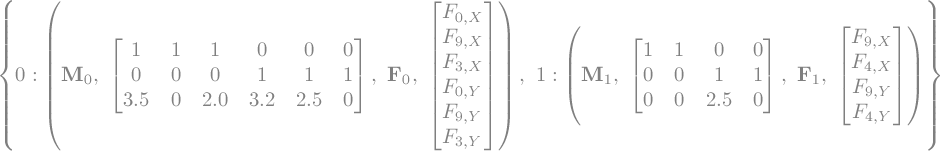

In [16]:
balance.d_member_forceinfo

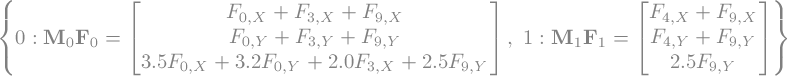

In [17]:
balance.d_member_forcemoment

# Visualization

To view these structures in 3D online, go to:
   - [Simple structure #1](https://htmlpreview.github.io/?https://github.com/cstarkjp/ConceptualDesign/blob/main/Plots/simpleStructure1.html)
   - [Standing tower #1](https://htmlpreview.github.io/?https://github.com/cstarkjp/ConceptualDesign/blob/main/Plots/standingTower1.html)

In [18]:
viz = Visualization(font_name="Arial")

Need to cross-ref applied load triangles to actual graph and pvmesh triangles – if we want to label the load triangles in 3D.

In [19]:
pvmesh = viz.build_pvmesh(topology)

In [20]:
plotter = viz.plot_model_3d(
    pvmesh,
    graph, 
    forces,
    backend="trame", 
    do_appliedload_labels=True,
    font_size=15,
)

Widget(value="<iframe src='http://localhost:60360/index.html?ui=P_0x16307b370_0&reconnect=auto' style='width: …

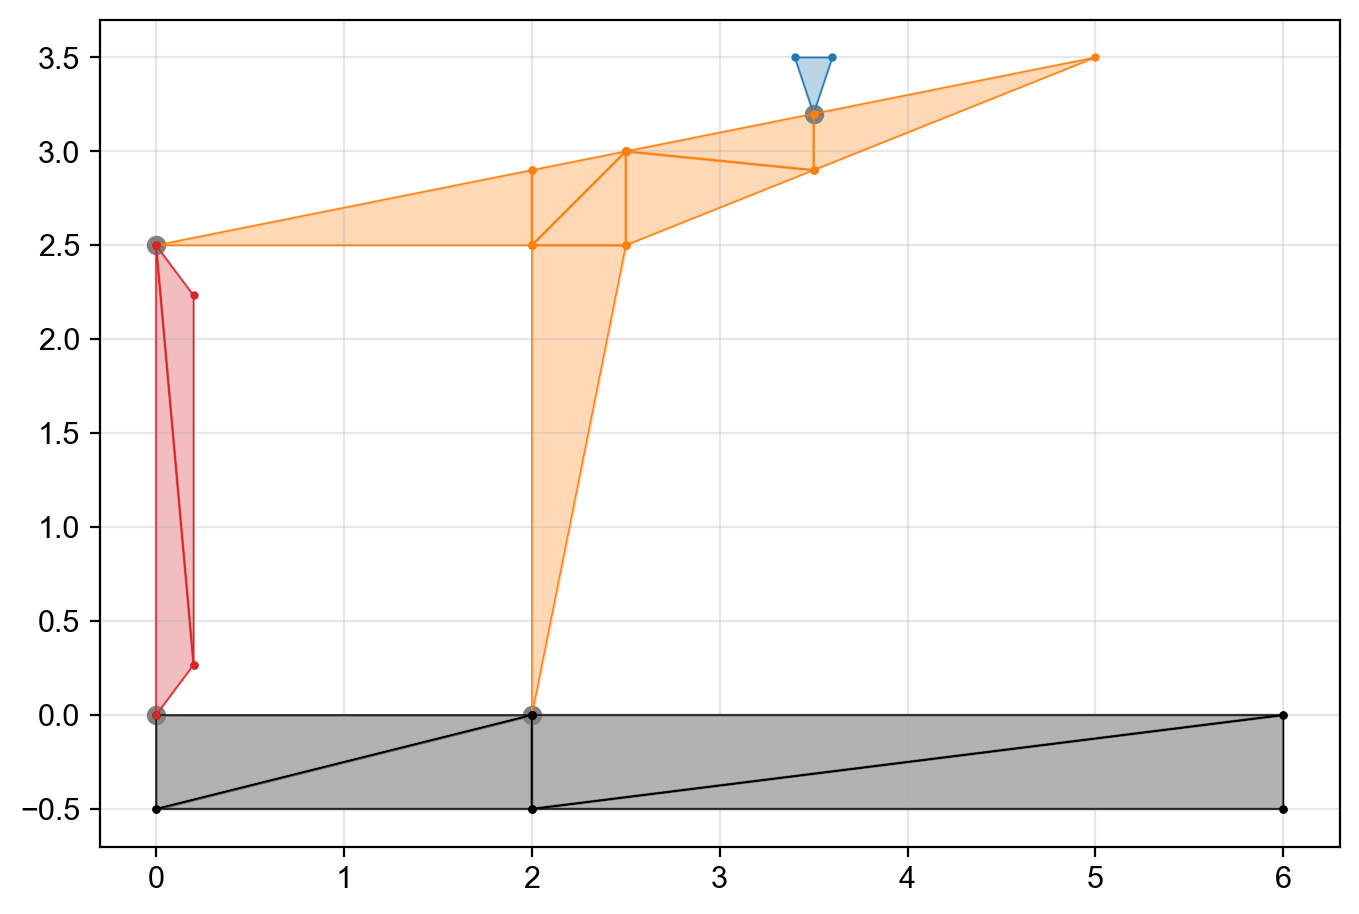

In [21]:
viz.plot_model_2D(name, graph, communities, topology)

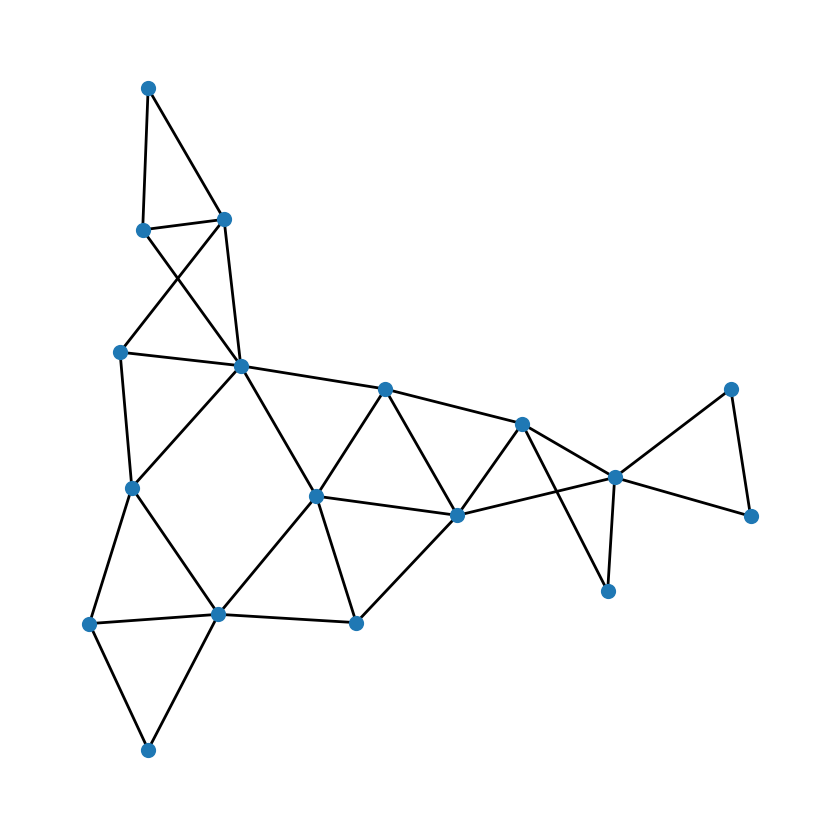

In [22]:
viz.plot_network_graph(name, graph, fig_size=(4,4,),)

# Export

In [23]:
plots_dirname = "Plots"
plots_path = create_directories(("..",), plots_dirname)
for gr_ in [viz]:    
    export_plots( gr_.fdict, plots_path, file_types=["jpg"], dpi=100 )

In [24]:
plotter.export_html(os.path.join(plots_path, f"{name}.html"))